In [1]:
import sys, os
from pathlib import Path
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

## Load flooding configuration file from local device or gcs

In [2]:
from ml4floods.models.config_setup import get_default_config
import pkg_resources

# Set filepath to configuration files
# config_fp = 'path/to/worldfloods_template.json'
config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")

config = get_default_config(config_fp)

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': 'worldfloods',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]}

## Step 2: Setup Dataloader

In [3]:
# config.experiment_name = 'training_flooding_rgb_full_UNET'
# config.data_params.channel_configuration = 'rgb'
# config.data_params.window_size = [572,572]
# config.data_params.batch_size = 48
config.experiment_name = 'training_flooding_rgb'
config.data_params.channel_configuration = 'rgb'
config.data_params.window_size = [256,256]
config.data_params.batch_size = 48
config.model_params.hyperparameters.channel_configuration = 'rgb'
config.model_params.hyperparameters.num_channels = 3
config.data_params.bucket_id = ""
config.data_params.num_workers = 4
config

{'experiment_name': 'training_flooding_rgb',
 'seed': 12,
 'model_params': {'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 256,
   'metric_monitor': 'val_dice_loss',
   'channel_configuration': 'rgb',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'linear',
   'num_classes': 3,
   'max_epochs': 10,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 3},
  'train': True,
  'test': True},
 'data_params': {'loader_type': 'local',
  'num_workers': 4,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': '',
  'path_to_splits': 'worldfloods',
  'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
  'input_folder': 'S2',
  'target_f

In [4]:
%%time

from ml4floods.models.dataset_setup import get_dataset

# config.data_params.batch_size = 96 # control this depending on the space on your GPU!
config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/mnt/d/Flooding/worldfloods_v1_sample" # local folder to download the data
config.data_params.train_test_split_file = "/mnt/d/Flooding/train_test_split.json"

config.data_params["download"] = {"train": True, "val": True, "test": True} # download only test data
# config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json" # use this to train with all the data

# If files are not in config.data_params.path_to_splits this will trigger the download of the products.
dataset = get_dataset(config.data_params)

Using local dataset for this run
train 194151  tiles
val 1284  tiles
test 11  tiles
CPU times: user 5.9 s, sys: 3.35 s, total: 9.24 s
Wall time: 14.8 s


## Verfify data loader

#### Verify training data
Data format here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [5]:
train_dl = dataset.train_dataloader()
train_dl_iter = iter(train_dl)
print(len(train_dl_iter))
batch_train = next(train_dl_iter)

# batch_train["image"].shape, batch_train["mask"].shape

4045


Verify validation data

In [6]:
val_dl = dataset.val_dataloader()

val_dl_iter = iter(val_dl)
print(len(val_dl_iter))
batch_val = next(val_dl_iter)

# batch_val["image"].shape, batch_val["mask"].shape

27


In [7]:
test_dl = dataset.test_dataloader()

test_dl_iter = iter(test_dl)
print(len(test_dl_iter))

batch_test = next(test_dl_iter)
# batch_test["image"].shape, batch_test["mask"].shape

11


### Plot batch by using ml4flood model 
check detail here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [8]:
import importlib
import matplotlib.pyplot as plt
from models import flooding_model
flooding_model = importlib.reload(flooding_model)

# batch_train_rgb = flooding_model.batch_to_unnorm_rgb(batch_train["image"])
# # batch_train_rgb.shape
# plt.imshow(batch_train_rgb[2])
# plt.show()

# batch_train_rgb_mask = flooding_model.batch_mask_to_rgb(batch_train["mask"])
# plt.imshow(batch_train_rgb_mask[2])
# plt.colorbar()
# plt.show()


## Step 3: Setup Model

In [9]:
 # folder to store the trained model (it will create a subfolder with the name of the experiment)
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'rgb',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 3},
 'train': True,
 'test': True}

In [10]:
config.model_params.model_folder = "train_models" 
os.makedirs("train_models", exist_ok=True)
config.model_params.test = False
config.model_params.train = True
config.model_params.hyperparameters.model_type = "unet" # Currently implemented: simplecnn, unet, linear, full_unet
# config.model_params.hyperparameters.max_tile_size = 572
config.model_params.hyperparameters.max_tile_size = 256
# config.model_params.hyperparameters.num_channels = 3

In [11]:
import copy
from models.flooding_model import WorldFloodsModel, DistilledTrainingModel
importlib.reload(flooding_model)
simple_model_params = copy.deepcopy(config.model_params)
# simple_model_params['hyperparameters']['model_type']="full_unet"

# model = DistilledTrainingModel(config.model_params, simple_model_params)
model = WorldFloodsModel(config.model_params)
net = model.network
net

num of channels:  3 , num of classes:  3


UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [12]:
# Compuatation complexity of network
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(net, (config.model_params.hyperparameters.num_channels, config.model_params.hyperparameters.max_tile_size, config.model_params.hyperparameters.max_tile_size), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

UNet(
  7.783 M, 100.000% Params, 42.473 GMac, 100.000% MACs, 
  (dconv_down1): Sequential(
    0.039 M, 0.497% Params, 2.546 GMac, 5.994% MACs, 
    (0): Conv2d(0.002 M, 0.023% Params, 0.117 GMac, 0.277% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0.0 M, 0.000% Params, 0.004 GMac, 0.010% MACs, inplace=True)
    (2): Conv2d(0.037 M, 0.474% Params, 2.42 GMac, 5.698% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0.0 M, 0.000% Params, 0.004 GMac, 0.010% MACs, inplace=True)
  )
  (dconv_down2): Sequential(
    0.221 M, 2.845% Params, 3.632 GMac, 8.552% MACs, 
    (0): Conv2d(0.074 M, 0.949% Params, 1.21 GMac, 2.849% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0.0 M, 0.000% Params, 0.002 GMac, 0.005% MACs, inplace=True)
    (2): Conv2d(0.148 M, 1.896% Params, 2.418 GMac, 5.693% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0.0 M, 0.000% Params, 0.002 GMac

In [13]:
setup_weights_and_biases = False
if setup_weights_and_biases:
    import wandb
    from pytorch_lightning.loggers import WandbLogger

    # UNCOMMENT ON FIRST RUN TO LOGIN TO Weights and Biases (only needs to be done once)
    # wandb.login()
    # run = wandb.init()

    # Specifies who is logging the experiment to wandb
    config['wandb_entity'] = 'ml4floods'
    # Specifies which wandb project to log to, multiple runs can exist in the same project
    config['wandb_project'] = 'worldfloods-notebook-demo-project'

    wandb_logger = WandbLogger(
        name=config.experiment_name,
        project=config.wandb_project, 
        entity=config.wandb_entity
    )
else:
    wandb_logger = None

In [14]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_dice_loss',
    mode='min',
#     prefix=''
)

early_stop_callback = EarlyStopping(
    monitor='val_dice_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)

callbacks = [checkpoint_callback, early_stop_callback]

print(f"The trained model will be stored in {config.model_params.model_folder}/{config.experiment_name}")

The trained model will be stored in train_models/training_flooding_rgb


In [15]:
from pytorch_lightning import Trainer

config.gpus = 4 # which gpu to use

# config.gpus = None # to not use GPU

config.model_params.hyperparameters.max_epochs = 40 # train for maximum 4 epochs

# trainer = Trainer(
#     fast_dev_run=False,
#     logger=wandb_logger,
#     callbacks=callbacks,
#     default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
#     accumulate_grad_batches=1,
#     gradient_clip_val=0.0,
#     auto_lr_find=False,
#     benchmark=False,
#     distributed_backend=None,
#     gpus=config.gpus,
#     max_epochs=config.model_params.hyperparameters.max_epochs,
#     check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
#     log_gpu_memory=False,
#     resume_from_checkpoint='./train_models/training_flooding_rgb/checkpoint/epoch=29-step=182039.ckpt',
#     accelerator='dp'
# )

trainer = Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=callbacks,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    distributed_backend=None,
    gpus=config.gpus,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    log_gpu_memory=False,
    accelerator='dp'
)
# config
# https://wandb.ai/wandb/wandb-lightning/reports/Multi-GPU-Training-Using-PyTorch-Lightning--VmlldzozMTk3NTk

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6,7]

  | Name    | Type | Params
---------------------------------
0 | network | UNet | 7.8 M 
---------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.132    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/eeaiserver/pt-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 4044: val_dice_loss reached 0.68704 (best 0.68704), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_rgb/checkpoint/epoch=0-step=4044.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 8089: val_dice_loss reached 0.64631 (best 0.64631), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_rgb/checkpoint/epoch=1-step=8089.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 12134: val_dice_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 16179: val_dice_loss reached 0.50446 (best 0.50446), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_rgb/checkpoint/epoch=3-step=16179.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 20224: val_dice_loss reached 0.43789 (best 0.43789), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_rgb/checkpoint/epoch=4-step=20224.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 24269: val_dice_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 28314: val_dice_loss reached 0.42891 (best 0.42891), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_rgb/checkpoint/epoch=6-step=28314.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 32359: val_dice_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 36404: val_dice_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 40449: val_dice_loss was not in top True


Epoch    10: reducing learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 44494: val_dice_loss reached 0.41210 (best 0.41210), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_rgb/checkpoint/epoch=10-step=44494.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 48539: val_dice_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 52584: val_dice_loss reached 0.39391 (best 0.39391), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_rgb/checkpoint/epoch=12-step=52584.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 56629: val_dice_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 60674: val_dice_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 64719: val_dice_loss was not in top True


Epoch    16: reducing learning rate of group 0 to 2.5000e-05.


In [26]:
import torch
# Run inference on the images shown before

logits = model(batch_train["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([48, 3, 256, 256])
Shape of probs: torch.Size([48, 3, 256, 256])
Shape of prediction: torch.Size([48, 256, 256])


In [28]:
config.model_params.max_tile_size = config.model_params.hyperparameters.max_tile_size
config

{'experiment_name': 'training_flooding_rgb',
 'seed': 12,
 'model_params': {'model_folder': 'train_models',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 256,
   'metric_monitor': 'val_dice_loss',
   'channel_configuration': 'rgb',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'unet',
   'num_classes': 3,
   'max_epochs': 40,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 3},
  'train': True,
  'test': False,
  'max_tile_size': 256},
 'data_params': {'loader_type': 'local',
  'num_workers': 4,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': '',
  'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_sample',
  'train_test_split_file': '/mnt/d/Flooding/train_test_split.json',
  'input_folder': 'S2',
  'target_fo

  0%|          | 0/26 [00:00<?, ?it/s]

Getting model inference function
Max tile size: 256
48


27it [07:54, 17.57s/it]                        


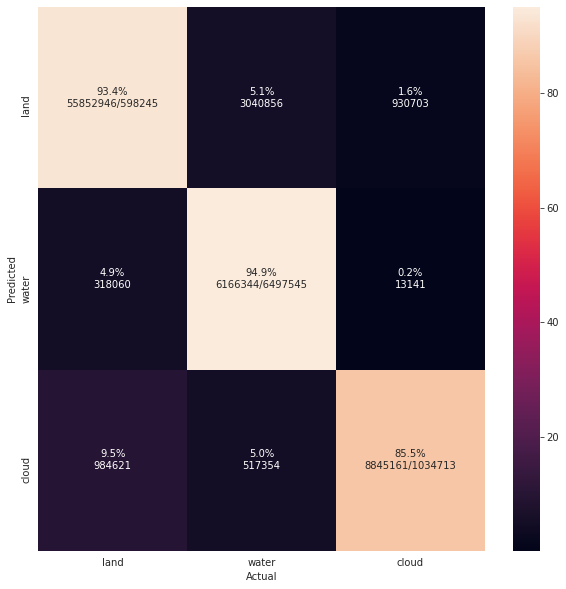

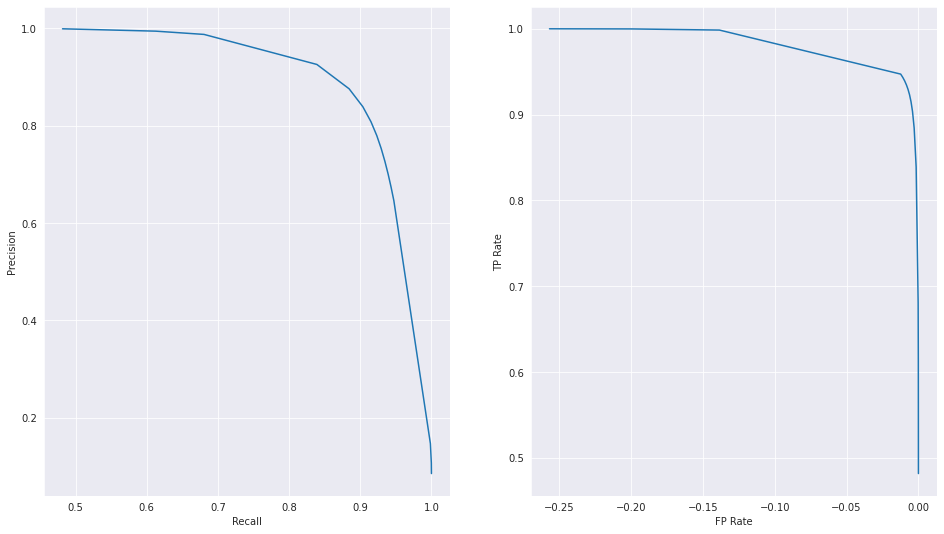

Per Class IOU {
    "cloud": 0.7833829304455223,
    "land": 0.9137169507525165,
    "water": 0.6132154174402233
}


In [30]:
# os.environ["CUDA_VISIBLE_DEVICES"]=""

import torch
import numpy as np
from ml4floods.models.utils import metrics
from ml4floods.models.model_setup import get_model_inference_function
import pandas as pd

# model.to("cuda")
inference_function = get_model_inference_function(model, config, apply_normalization=False, activation="softmax")

config.data_params.batch_size = 8
# print(config.data_params)
# dataset2 = get_dataset(config.data_params)
dl = dataset.val_dataloader() # pytorch Dataloader
print(str(dl.batch_size))

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    plot=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

In [32]:
if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 91.51434068064852, 'Recall_water': 87.11029905798348, 'Recall_cloud': 72.70301779369203, 'IoU_land': 89.73216436852466, 'IoU_water': 41.74102118565798, 'IoU_cloud': 66.43962463692607}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR271,87.193033,93.492954,88.700222,86.581023,35.051834,80.574376
EMSR279,88.820804,88.203756,84.771701,83.797797,33.847104,77.611091
EMSR280,96.906987,96.881936,77.078516,96.443001,80.544053,67.825548
EMSR287,91.560503,87.562386,1.070155,91.204170,20.882686,0.883219
RS2,87.413126,86.045806,89.724865,84.983249,31.392129,83.045421
ST1,97.191591,70.474958,94.872649,95.383747,48.728322,88.698092


In [34]:
import torch
from pytorch_lightning.utilities.cloud_io import atomic_save
from ml4floods.models.config_setup import save_json

# Save in the cloud and in the wandb logger save dir
atomic_save(model.state_dict(), f"{experiment_path}/model_rgb_unet_epoch_40.pt")
# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config_rgb_epoch_30.json"
save_json(config, config_file_path)

In [36]:
if setup_weights_and_biases:
    torch.save(model.state_dict(), os.path.join(wandb_logger.save_dir, 'model_rgb_unet_epoch_40.pt'))
    wandb.save(os.path.join(wandb_logger.save_dir, 'model_rgb_full_unet_epoch_4.pt')) # Copy weights to weights and biases server
    wandb.finish()

In [38]:
# Run inference on the images shown before

logits = model(batch_val["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([48, 3, 256, 256])
Shape of probs: torch.Size([48, 3, 256, 256])
Shape of prediction: torch.Size([48, 256, 256])


(3, 1, 1)


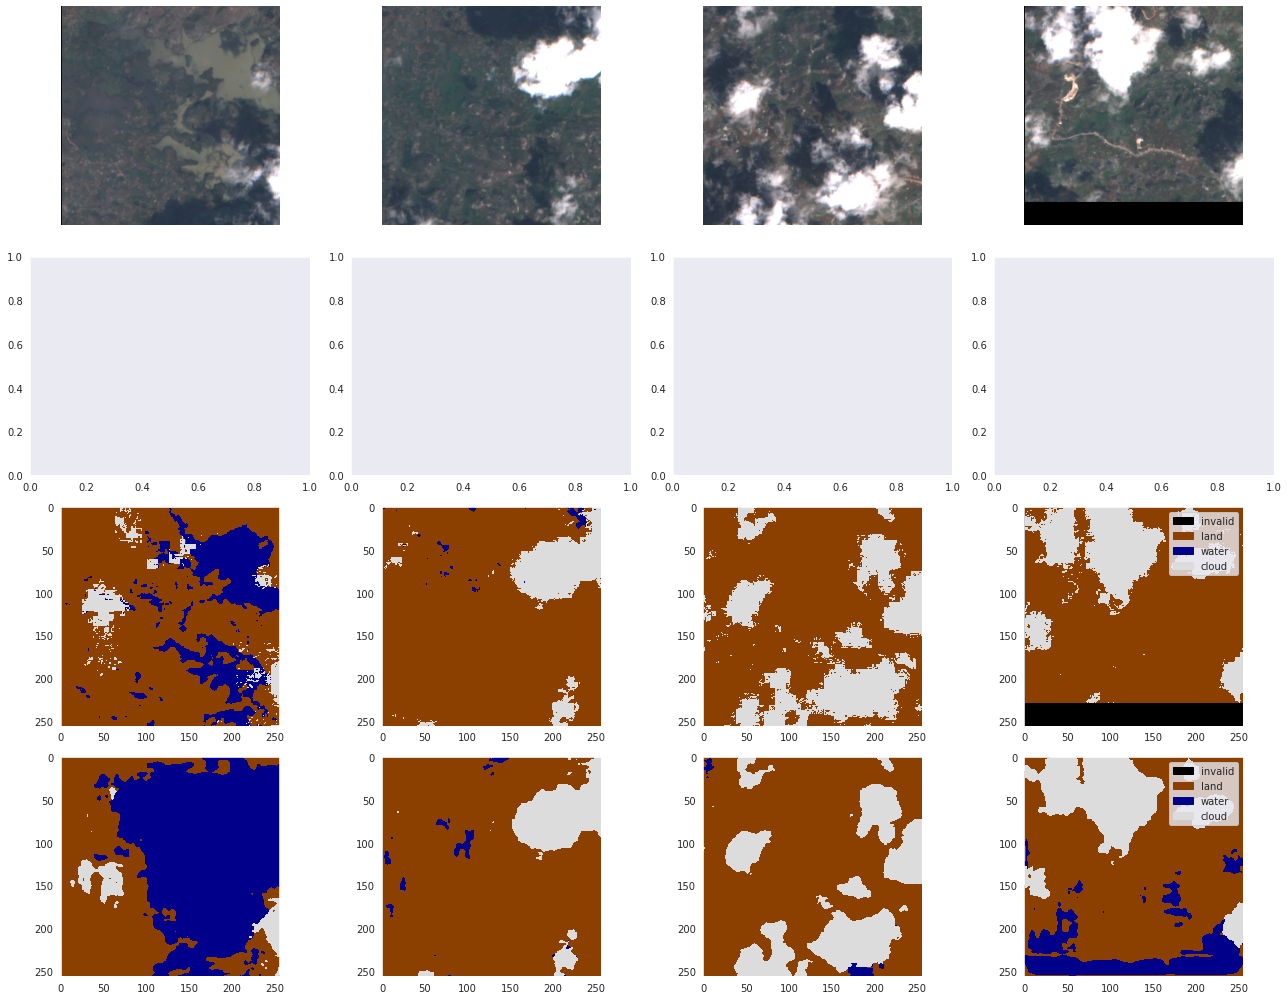

In [40]:
n_image_start=0
n_images=4
count=int(n_images-n_image_start)
fig, axs = plt.subplots(4, count, figsize=(18,14),tight_layout=True)
importlib.reload(flooding_model)
flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="rgb",axs=axs[0],max_clip_val=3500.)
# flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="bgri",bands_show=["B8","B8", "B8"],axs=axs[1],max_clip_val=3500.)
# flooding_model.plot_batch(batch_val["image"][:n_images],bands_show=["B11","B8", "B4"],axs=axs[1],max_clip_val=4500.)
flooding_model.plot_batch_output_v1(batch_val["mask"][n_image_start:n_images, 0],axs=axs[2], show_axis=True)
flooding_model.plot_batch_output_v1(prediction[n_image_start:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)